# Web Extension for Online Sentiment Detection
## Andrew Burton, Kyle West, Aneel Parmar
### Computer Science 571 - Winter 2024
#### Design and implementation of Database Systems

# Introduction
...
## Problem Statement
...
## Objectives
...
## Methodology
...

# Data Preparation

## Load the Data

In [5]:
import pandas as pd
from datasets import load_dataset

dataset_name, dataset_config_name = 'go_emotions', 'simplified'
train_data, test_data = load_dataset(dataset_name, dataset_config_name, split=['train', 'test'])

train_df = pd.DataFrame(train_data, columns=['text', 'labels'])
test_df = pd.DataFrame(test_data, columns=['text', 'labels'])

## Define the Labels

In [6]:
labels = train_data.features['labels'].feature.names
id2label = {k: v for k, v in enumerate(labels)}
label2id = {v: k for k, v in id2label.items()}
print(id2label)
print(label2id)

{0: 'admiration', 1: 'amusement', 2: 'anger', 3: 'annoyance', 4: 'approval', 5: 'caring', 6: 'confusion', 7: 'curiosity', 8: 'desire', 9: 'disappointment', 10: 'disapproval', 11: 'disgust', 12: 'embarrassment', 13: 'excitement', 14: 'fear', 15: 'gratitude', 16: 'grief', 17: 'joy', 18: 'love', 19: 'nervousness', 20: 'optimism', 21: 'pride', 22: 'realization', 23: 'relief', 24: 'remorse', 25: 'sadness', 26: 'surprise', 27: 'neutral'}
{'admiration': 0, 'amusement': 1, 'anger': 2, 'annoyance': 3, 'approval': 4, 'caring': 5, 'confusion': 6, 'curiosity': 7, 'desire': 8, 'disappointment': 9, 'disapproval': 10, 'disgust': 11, 'embarrassment': 12, 'excitement': 13, 'fear': 14, 'gratitude': 15, 'grief': 16, 'joy': 17, 'love': 18, 'nervousness': 19, 'optimism': 20, 'pride': 21, 'realization': 22, 'relief': 23, 'remorse': 24, 'sadness': 25, 'surprise': 26, 'neutral': 27}


### Data Exploration

#### Train Data

In [7]:
display(train_df.head())

,text,labels
0,My favourite food is anything I didn't have to...,[27]
1,"Now if he does off himself, everyone will thin...",[27]
2,WHY THE FUCK IS BAYLESS ISOING,[2]
3,To make her feel threatened,[14]
4,Dirty Southern Wankers,[3]


##### Distribution of Text Length

<Axes: ylabel='Frequency'>

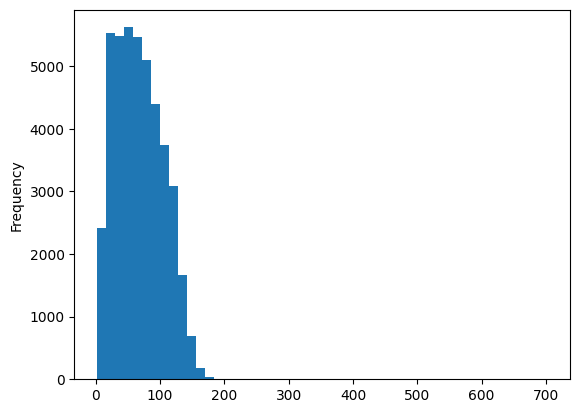

In [8]:
text_lengths = train_df['text'].str.len()
text_lengths.plot.hist(bins=50)

##### Distribution of Label Counts

In [9]:
class_counts = [ c for cls in train_df['labels'] for c in cls]
class_counts_series = pd.Series(class_counts).value_counts()
sorted_cls_df = pd.DataFrame(class_counts_series, columns=['class_count']).sort_index()
display(sorted_cls_df)

,class_count


#### Test Data

In [10]:
display(test_df.head())

,text,labels
0,I’m really sorry about your situation :( Altho...,[25]
1,It's wonderful because it's awful. At not with.,[0]
2,"Kings fan here, good luck to you guys! Will be...",[13]
3,"I didn't know that, thank you for teaching me ...",[15]
4,They got bored from haunting earth for thousan...,[27]


##### Distribution of Text Length

<Axes: ylabel='Frequency'>

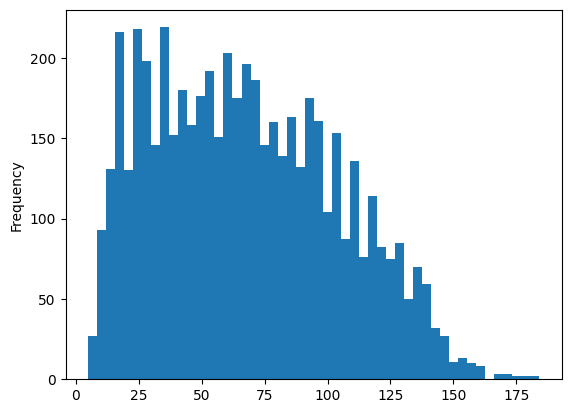

In [11]:
text_lengths = test_df['text'].str.len()
text_lengths.plot.hist(bins=50)

##### Distribution of Label Counts

In [12]:
class_counts = [ c for cls in test_df['labels'] for c in cls]
class_counts_series = pd.Series(class_counts).value_counts()
sorted_cls_df = pd.DataFrame(class_counts_series, columns=['class_count']).sort_index()
display(sorted_cls_df)

,class_count


# Label Encoding

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(train_df['labels']).astype('float32')
texts = train_df['text'].tolist()

In [14]:
display(labels)

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [15]:
display(texts[:5])

["My favourite food is anything I didn't have to cook myself.",
 'Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead',
 'WHY THE FUCK IS BAYLESS ISOING',
 'To make her feel threatened',
 'Dirty Southern Wankers']

# Model Building

In [16]:
import torch
from transformers import DistilBertTokenizer, AutoTokenizer
from transformers import DistilBertForSequenceClassification, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

In [17]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [18]:
checkpoint = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(checkpoint)
model = DistilBertForSequenceClassification.from_pretrained(checkpoint, num_labels=len(labels[0]), problem_type='multi_label_classification')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
labels[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [20]:
class CustomDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len=128):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    label = torch.tensor(self.labels[idx])

    encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')

    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'labels': label
    }

In [21]:
train_set = CustomDataset(train_texts, train_labels, tokenizer)
val_set = CustomDataset(val_texts, val_labels, tokenizer)

In [22]:
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, hamming_loss
from transformers import EvalPrediction
import torch

def multi_labels_metrics(preds, labels, threshold=0.3):
  sigmoid = torch.nn.Sigmoid()
  probs = sigmoid(torch.Tensor(preds))

  y_pred = np.zeros(probs.shape)
  y_pred[np.where(probs >= threshold)] = 1
  y_true = labels

  f1 = f1_score(y_true, y_pred, average='macro')
  roc_auc = roc_auc_score(y_true, y_pred, average='macro')
  hamming = hamming_loss(y_true, y_pred)

  metrics = {
      'f1': f1,
      'roc_auc': roc_auc,
      'hamming': hamming
  }

  return metrics

def compute_metrics(p: EvalPrediction):
  preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
  result = multi_labels_metrics(preds, p.label_ids)
  return result

In [23]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    output_dir = './results',
    num_train_epochs=5,
    save_steps=1000,
    save_total_limit=2
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_set,
    eval_dataset = val_set,
    compute_metrics=compute_metrics
)

2024-03-15 21:36:23.433616: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/andrew/PycharmProjects/CPSC571Group/backend/venv/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [24]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=2715, training_loss=0.08706728476845757, metrics={'train_runtime': 4373.0186, 'train_samples_per_second': 39.707, 'train_steps_per_second': 0.621, 'total_flos': 5753076085923840.0, 'train_loss': 0.08706728476845757, 'epoch': 5.0})

In [25]:
trainer.evaluate()

{'eval_loss': 0.09134741872549057,
 'eval_f1': 0.46975327620209933,
 'eval_roc_auc': 0.7286258071992433,
 'eval_hamming': 0.03580478494092869,
 'eval_runtime': 65.0911,
 'eval_samples_per_second': 133.382,
 'eval_steps_per_second': 2.089,
 'epoch': 5.0}

In [26]:
trainer.save_model('./team_5_head_model')

# Test on a sample text

In [27]:
text = "My favourite food is anything I didn't have to cook myself."

encoding = tokenizer(text, return_tensors='pt')
encoding.to(trainer.model.device)
output = trainer.model(**encoding)
print(output)

SequenceClassifierOutput(loss=None, logits=tensor([[-3.3212, -4.9535, -7.4705, -6.5628, -1.4791, -5.0259, -7.8358, -6.5386,
         -5.0252, -7.2736, -7.3794, -7.5843, -7.8336, -4.0764, -9.3607, -5.9908,
         -7.4174, -1.4071, -0.6576, -7.8141, -6.2287, -6.6253, -5.2202, -5.3411,
         -8.0496, -6.6154, -8.5554, -1.7182]], device='mps:0',
       grad_fn=<LinearBackward0>), hidden_states=None, attentions=None)


In [37]:
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(output.logits[0].cpu())
probs_detach = probs.detach().numpy()  # Detach the tensor and convert to numpy array
preds = np.zeros(probs_detach.shape)
preds[np.where(probs_detach >= 0.3)] = 1
labels = mlb.inverse_transform(preds.reshape(1, -1))
print(["{:.2f}".format(val) for val in probs_detach])
print(preds)
print(labels)

['0.03', '0.01', '0.00', '0.00', '0.19', '0.01', '0.00', '0.00', '0.01', '0.00', '0.00', '0.00', '0.00', '0.02', '0.00', '0.00', '0.00', '0.20', '0.34', '0.00', '0.00', '0.00', '0.01', '0.00', '0.00', '0.00', '0.00', '0.15']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[(18,)]
